In [1]:
import os, random, glob, pickle, collections
import numpy as np
import pandas as pd
import ujson as json
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import GlobalAveragePooling2D, Flatten, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('tf')

from skimage.data import imread
from skimage.io import imshow,imsave
import cv2
from skimage.util import crop
from skimage.transform import rotate
from skimage.transform import resize
import math

Using TensorFlow backend.


In [2]:
TRAIN_DIR = '../data/train/'
TEST_DIR = '../RFCN/JPEGImages/'
TRAIN_CROP_DIR = '../data/train_crop/'
TEST_CROP_DIR = '../data/test_stg1_crop/'
FISH_CLASSES = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
CONF_THRESH = 0.8
ROWS = 224
COLS = 224
BatchSize = 128
LearningRate = 1e-4
le = LabelEncoder()
le.fit(FISH_CLASSES)
le.transform(FISH_CLASSES)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [5]:
#data preprocessing

train_datagen = ImageDataGenerator(
    featurewise_center=True,
    #featurewise_std_normalization=True,
    #rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=[0.9,1.1],
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train, y_train, batch_size=BatchSize, shuffle=True, seed=None)

valid_datagen = ImageDataGenerator(
    featurewise_center=True)
    #featurewise_std_normalization=True)
    #rescale=1./255
valid_datagen.fit(X_valid)   
valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=BatchSize, shuffle=True, seed=None)

In [6]:
#callbacks

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')        

model_checkpoint = ModelCheckpoint(filepath='./checkpoints/checkpoint2/weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        
learningrate_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', epsilon=0.001, cooldown=0, min_lr=0)

tensorboard = TensorBoard(log_dir='./logs/log2', histogram_freq=0, write_graph=True, write_images=True)


In [ ]:
#Resnet50
#stg1 training

from keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)
#x = Dense(256, init='glorot_normal', activation='relu')(x)
#x = LeakyReLU(alpha=0.33)(x)
#x = Dropout(0.5)(x)
#x = Dense(256, init='glorot_normal', activation='relu')(x)
#x = LeakyReLU(alpha=0.33)(x)
#x = Dropout(0.5)(x)
predictions = Dense(len(FISH_CLASSES), init='glorot_normal', activation='softmax')(x)

# this is the model we will train
model = Model(input=base_model.input, output=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
model.fit_generator(train_generator, samples_per_epoch=len(X_train), nb_epoch=30, verbose=1, 
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=valid_generator, nb_val_samples=len(X_valid), nb_worker=3, pickle_safe=True)

Epoch 1/30
15488/15583 [============================>.] - ETA: 1s - loss: 1.6035 - acc: 0.4657

/opt/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1470: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: val_loss improved from inf to 1.40994, saving model to ./checkpoints/checkpoint2/weights.000-1.4099.hdf5
15616/15583 [==============================] - 258s - loss: 1.5997 - acc: 0.4674 - val_loss: 1.4099 - val_acc: 0.7684
Epoch 2/30
15616/15583 [==============================] - 248s - loss: 1.2042 - acc: 0.6918 - val_loss: 1.3130 - val_acc: 0.7530
Epoch 3/30
15645/15583 [==============================] - 250s - loss: 1.0546 - acc: 0.7473 - val_loss: 1.2446 - val_acc: 0.7581
Epoch 4/30
15616/15583 [==============================] - 248s - loss: 0.9808 - acc: 0.7554 - val_loss: 1.1963 - val_acc: 0.7629
Epoch 5/30
15616/15583 [==============================] - 247s - loss: 0.9014 - acc: 0.7678 - val_loss: 1.1775 - val_acc: 0.7596
Epoch 6/30
 6528/15583 [===========>..................] - ETA: 115s - loss: 0.8754 - acc: 0.7782

In [10]:
#Resnet50
#stg2 training

# files = glob.glob('./checkpoints/*')
# val_losses = [float(f.split('-')[-1][:-5]) for f in files]
# index = val_losses.index(min(val_losses))
print('Loading model from checkpoints file weights.028-0.4157.hdf5')
model = load_model('./checkpoints/checkpoint2/weights.028-0.4157.hdf5')

from keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
#164
for layer in model.layers[:142]:
   layer.trainable = False
for layer in model.layers[142:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
optimizer = Adam(lr=LearningRate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(train_generator, samples_per_epoch=len(X_train), nb_epoch=300, verbose=1, 
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=valid_generator, nb_val_samples=len(X_valid), nb_worker=3, pickle_safe=True)

Loading model from checkpoints file weights.028-0.4157.hdf5
0 input_1
1 zeropadding2d_1
2 conv1
3 bn_conv1
4 activation_1
5 maxpooling2d_1
6 res2a_branch2a
7 bn2a_branch2a
8 activation_2
9 res2a_branch2b
10 bn2a_branch2b
11 activation_3
12 res2a_branch2c
13 res2a_branch1
14 bn2a_branch2c
15 bn2a_branch1
16 merge_1
17 activation_4
18 res2b_branch2a
19 bn2b_branch2a
20 activation_5
21 res2b_branch2b
22 bn2b_branch2b
23 activation_6
24 res2b_branch2c
25 bn2b_branch2c
26 merge_2
27 activation_7
28 res2c_branch2a
29 bn2c_branch2a
30 activation_8
31 res2c_branch2b
32 bn2c_branch2b
33 activation_9
34 res2c_branch2c
35 bn2c_branch2c
36 merge_3
37 activation_10
38 res3a_branch2a
39 bn3a_branch2a
40 activation_11
41 res3a_branch2b
42 bn3a_branch2b
43 activation_12
44 res3a_branch2c
45 res3a_branch1
46 bn3a_branch2c
47 bn3a_branch1
48 merge_4
49 activation_13
50 res3b_branch2a
51 bn3b_branch2a
52 activation_14
53 res3b_branch2b
54 bn3b_branch2b
55 activation_15
56 res3b_branch2c
57 bn3b_branch2c


/opt/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1470: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: val_loss improved from 0.41571 to 0.22631, saving model to ./checkpoints/checkpoint2/weights.000-0.2263.hdf5
15616/15583 [==============================] - 296s - loss: 0.2269 - acc: 0.9276 - val_loss: 0.2263 - val_acc: 0.9274
Epoch 2/300
15616/15583 [==============================] - 279s - loss: 0.1271 - acc: 0.9605 - val_loss: 0.1506 - val_acc: 0.9483
Epoch 3/300
15645/15583 [==============================] - 283s - loss: 0.0818 - acc: 0.9746 - val_loss: 0.1408 - val_acc: 0.9619
Epoch 4/300
15616/15583 [==============================] - 280s - loss: 0.0592 - acc: 0.9817 - val_loss: 0.0761 - val_acc: 0.9768
Epoch 5/300
15616/15583 [==============================] - 280s - loss: 0.0499 - acc: 0.9838 - val_loss: 0.0565 - val_acc: 0.9844
Epoch 6/300
15645/15583 [==============================] - 280s - loss: 0.0470 - acc: 0.9856 - val_loss: 0.0788 - val_acc: 0.9776
Epoch 7/300
15616/15583 [==============================] - 279s - loss: 0.0330 - acc: 0.9899 - val_loss: 0.061

KeyboardInterrupt: 

In [9]:
#resume training

files = glob.glob('./checkpoints/checkpoint2/*')
val_losses = [float(f.split('-')[-1][:-5]) for f in files]
index = val_losses.index(min(val_losses))
print('Loading model from checkpoints file ' + files[index])
model = load_model(files[index])

model.fit_generator(train_generator, samples_per_epoch=len(X_train), nb_epoch=30, verbose=1, 
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=valid_generator, nb_val_samples=len(X_valid), nb_worker=3, pickle_safe=True)

Loading model from checkpoints file ./checkpoints/checkpoint2/weights.004-1.1775.hdf5
Epoch 1/30
15488/15583 [============================>.] - ETA: 1s - loss: 0.8447 - acc: 0.7795

/opt/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1470: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: val_loss improved from inf to 1.02681, saving model to ./checkpoints/checkpoint2/weights.000-1.0268.hdf5
15616/15583 [==============================] - 291s - loss: 0.8449 - acc: 0.7791 - val_loss: 1.0268 - val_acc: 0.7845
Epoch 2/30
15616/15583 [==============================] - 244s - loss: 0.7965 - acc: 0.7874 - val_loss: 0.9675 - val_acc: 0.7742
Epoch 3/30
15645/15583 [==============================] - 246s - loss: 0.7738 - acc: 0.7927 - val_loss: 0.8449 - val_acc: 0.7858
Epoch 4/30
15616/15583 [==============================] - 244s - loss: 0.7229 - acc: 0.8016 - val_loss: 0.7443 - val_acc: 0.7956
Epoch 5/30
15616/15583 [==============================] - 244s - loss: 0.6862 - acc: 0.8055 - val_loss: 0.6607 - val_acc: 0.8145
Epoch 6/30
15645/15583 [==============================] - 243s - loss: 0.6774 - acc: 0.8113 - val_loss: 0.6671 - val_acc: 0.8128
Epoch 7/30
15616/15583 [==============================] - 243s - loss: 0.6512 - acc: 0.8159 - val_loss: 0.6110 - val_ac

In [3]:
#get GT_crop_BBClassifier_preds 

print ('Exist data_train_BBCrop_{}_{}.pickle. Loading data from file.'.format(ROWS, COLS))
with open('../data/data_train_BBCrop_{}_{}.pickle'.format(ROWS, COLS), 'rb') as f:
    data_train = pickle.load(f)
X_train_crop = data_train['X_train_crop']
y_train_crop = data_train['y_train_crop']
GT_crop_files = data_train['train_crop_files']

X_train_crop = X_train_crop / 255.

print('Loading model from weights.004-0.0565.hdf5')
model = load_model('./checkpoints/checkpoint2/weights.004-0.0565.hdf5')
GT_crop_preds = model.predict(X_train_crop, batch_size=BatchSize, verbose=1)

GT_crop_preds_df = pd.DataFrame(GT_crop_preds, columns=['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT'])
GT_crop_preds_df.insert(0,'GT_crop_files',GT_crop_files)

GT_crop_bboxs_df = pd.read_pickle('../data/train_crop/GT_crop_files_BBox.pickle')

GT_crop_BBClassifier_preds = pd.merge(GT_crop_bboxs_df, GT_crop_preds_df) 

GT_crop_BBClassifier_preds['image_files'] = GT_crop_BBClassifier_preds.GT_crop_files.apply(lambda x: 'img_'+x.split('_')[2])
GT_crop_BBClassifier_preds['gt'] = GT_crop_BBClassifier_preds.GT_crop_files.apply(lambda x: x.split('_')[-1][:-4])

columns_reorder = ['image_files', 'gt', 'GT_crop_files', 'xmin', 'ymin', 'xmax', 'ymax', 'NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']
GT_crop_BBClassifier_preds = GT_crop_BBClassifier_preds[columns_reorder]

GT_crop_BBClassifier_preds.head()

Exist data_train_BBCrop_224_224.pickle. Loading data from file.
Loading model from weights.004-0.0565.hdf5
19479/19479 [==============================] - 193s   


image_files   gt            GT_crop_files   xmin   ymin    xmax   ymax  \
0   img_00003  ALB  ALB_img_00003_0_ALB.jpg  377.0   66.0   730.0  173.0   
1   img_00003  ALB  ALB_img_00003_1_ALB.jpg  670.0   95.0  1008.0  219.0   
2   img_00003  ALB  ALB_img_00003_2_ALB.jpg  820.0  328.0  1123.0  485.0   
3   img_00003  ALB  ALB_img_00003_3_ALB.jpg  291.0  122.0   643.0  407.0   
4   img_00010  ALB  ALB_img_00010_0_ALB.jpg  651.0  422.0   746.0  612.0   

        NoF       ALB       BET       DOL       LAG     OTHER     SHARK  \
0  0.558493  0.300522  0.003627  0.001613  0.034494  0.022477  0.010447   
1  0.382052  0.572772  0.000429  0.000562  0.018941  0.000832  0.000794   
2  0.034516  0.392461  0.000061  0.000022  0.567952  0.000150  0.000003   
3  0.026499  0.959248  0.000252  0.000010  0.003245  0.000169  0.000014   
4  0.292220  0.704831  0.000027  0.000032  0.000985  0.001628  0.000227   

        YFT  
0  0.068328  
1  0.023618  
2  0.004835  
3  0.010563  
4  0.000050

In [19]:
#train logloss
log_losses = []

for index,row in GT_crop_BBClassifier_preds.iterrows():
    log_losses.append(-math.log(row[row['gt']]))
                      
log_loss = sum(log_losses) / float(len(log_losses))
print('logloss of train is', log_loss )

logloss of train is 0.31262160237355224


In [4]:
#get RFCN bbox from detections_full_AGNOSTICnms.pkl
RFCN_MODEL = 'resnet101_rfcn_ohem_iter_30000'

import pickle 
with open('../data/RFCN_detections/detections_full_AGNOSTICnms_'+RFCN_MODEL+'.pkl','rb') as f:
    detections_full_AGNOSTICnms = pickle.load(f, encoding='latin1') 
    
outputs = []
count = np.zeros(len(detections_full_AGNOSTICnms))

for im in range(len(detections_full_AGNOSTICnms)):
    outputs_im = []
    detects_im = detections_full_AGNOSTICnms[im]
    for i in range(len(detects_im)):
        if np.max(detects_im[i,5:]) >= CONF_THRESH:
            outputs_im.append(detects_im[i,:]) 
    count[im] = len(outputs_im)
    if len(outputs_im) == 0:
        ind = np.argmax(np.max(detects_im[:,5:], axis=1))
        outputs_im.append(detects_im[ind,:])
    outputs_im = np.asarray(outputs_im)
    outputs.append(outputs_im)
    
#crop test images and cache to TEST_CROP_DIR

# if not os.path.exists(TEST_CROP_DIR):
#     os.mkdir(TEST_CROP_DIR)
# files = glob.glob(TEST_CROP_DIR+'*')
# for f in files:
#     os.remove(f)
    
# with open("../RFCN/ImageSets/Main/test.txt","r") as f:
#     ims = f.readlines()
# test_files = [im[:-1]+'.jpg' for im in ims]

# for i in range(len(outputs)):
#     if i%1000 == 0:
#         print(i)
#     filename = test_files[i]
#     bboxes = outputs[i]
#     basename, file_extension = os.path.splitext(filename) 
#     image = Image.open(TEST_DIR+filename)
#     for j in range(len(bboxes)):
#         bbox = bboxes[j]
#         xmin = bbox[0]
#         ymin = bbox[1]
#         xmax = bbox[2]
#         ymax = bbox[3]
#         file_crop = TEST_CROP_DIR+basename+'_{}'.format(j)+'.jpg'
#         cropped = image.crop((xmin, ymin, xmax, ymax))
#         width_cropped, height_cropped = cropped.size
#         if height_cropped > width_cropped: cropped = cropped.transpose(method=2)
#         cropped.save(file_crop)
        
print(sum([outputs[i].shape[0] for i in range(len(outputs))]))

6037


In [5]:
#get RFCN_crop_RFCN_preds
test_crop_preds = np.vstack(outputs)[:,:]

columns = ['x0', 'y0', 'x1', 'y1','NoF_RFCN', 'ALB_RFCN', 'BET_RFCN', 'DOL_RFCN', 'LAG_RFCN', 'OTHER_RFCN', 'SHARK_RFCN', 'YFT_RFCN']
RFCN_preds_df = pd.DataFrame(test_crop_preds, columns=columns)


with open("../RFCN/ImageSets/Main/test.txt","r") as f:
    ims = f.readlines()
test_files = [im[:-1]+'.jpg' for im in ims]

test_crop_files_RFCN = []
for i in range(len(outputs)):
    filename = test_files[i]
    basename, file_extension = os.path.splitext(filename) 
    for j in range(len(outputs[i])):
        file_crop = basename+'_{}_'.format(j)+'.jpg'
        test_crop_files_RFCN.append(file_crop)
        
RFCN_preds_df.insert(0, 'test_crop_files', test_crop_files_RFCN)

In [6]:
#Load test data

import datetime

def read_image(src):
    """Read and resize individual images"""
    im = Image.open(src)
    im = im.resize((COLS, ROWS), Image.BILINEAR)
    im = np.asarray(im)
    return im

if os.path.exists('../data/data_test_BBCrop_{}_{}.pickle'.format(ROWS, COLS)):
    print ('Exist data_test_BBCrop_{}_{}.pickle. Loading test data from file.'.format(ROWS, COLS))
    with open('../data/data_test_BBCrop_{}_{}.pickle'.format(ROWS, COLS), 'rb') as f:
        data_test = pickle.load(f)
    X_test_crop = data_test['X_test_crop']
    test_crop_files = data_test['test_crop_files']
else:
    print ('Loading test data from original images. Generating data_test_BBCrop_{}_{}.pickle.'.format(ROWS, COLS))

    test_crop_files = sorted([im for im in os.listdir(TEST_CROP_DIR)])
    X_test_crop = np.ndarray((len(test_crop_files), ROWS, COLS, 3), dtype=np.uint8)

    for i, im in enumerate(test_crop_files): 
        X_test_crop[i] = read_image(TEST_CROP_DIR+im)
        if i%1000 == 0: print('Processed {} of {}'.format(i, len(test_crop_files)))
            
    data_test = {'X_test_crop': X_test_crop,'test_crop_files': test_crop_files }
    
    with open('../data/data_test_BBCrop_{}_{}.pickle'.format(ROWS, COLS), 'wb') as f:
        pickle.dump(data_test, f, protocol=4)
        
X_test_crop = X_test_crop / 255.

Exist data_test_BBCrop_224_224.pickle. Loading test data from file.


In [7]:
#get RFCN_crop_BBClassifier_preds
print('Loading model from weights.004-0.0565.hdf5')
model = load_model('./checkpoints/checkpoint2/weights.004-0.0565.hdf5')
test_crop_preds = model.predict(X_test_crop, batch_size=BatchSize, verbose=1)

columns = ['ALB_BBCROP', 'BET_BBCROP', 'DOL_BBCROP', 'LAG_BBCROP', 'NoF_BBCROP', 'OTHER_BBCROP', 'SHARK_BBCROP', 'YFT_BBCROP']
BBCROP_preds_df = pd.DataFrame(test_crop_preds, columns=columns)

test_crop_files_BBCROP = test_crop_files
BBCROP_preds_df.insert(0, 'test_crop_files', test_crop_files_BBCROP)

Loading model from weights.004-0.0565.hdf5
6037/6037 [==============================] - 63s    


In [8]:
#get RFCN_crop_RFCN_BBClassifier_preds

test_preds_df = pd.merge(RFCN_preds_df, BBCROP_preds_df)  
test_preds_df['test_files'] = test_preds_df.test_crop_files.apply(lambda x: 'img_'+x.split('_')[1])

#add ground truth from ImageSets/Main/train_test.txt to test_preds_df
with open("../RFCN/ImageSets/Main/train_test.txt","r") as f:
    train_file_labels = f.readlines()
    
for index, row in test_preds_df.iterrows():
    im = row['test_files']
    gt = 'nan'
    logloss_RFCN = -np.inf
    logloss_BBCROP = -np.inf
    for im_label in train_file_labels:
        if im_label[:9] == im:
            gt = im_label[10:-1]
            logloss_RFCN = -math.log(row[gt+'_RFCN'])
            logloss_BBCROP = -math.log(row[gt+'_BBCROP'])
    test_preds_df.set_value(index,'gt',gt)
    test_preds_df.set_value(index,'logloss_RFCN',logloss_RFCN)
    test_preds_df.set_value(index,'logloss_BBCROP',logloss_BBCROP)
    
columns_reorder = ['test_files', 'gt', 'logloss_RFCN', 'logloss_BBCROP', 'test_crop_files', 'x0', 'y0', 'x1', 'y1']
FISH_CLASSES = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']
for c in FISH_CLASSES:
    columns_reorder.append(c+'_RFCN')
    columns_reorder.append(c+'_BBCROP')
test_preds_df = test_preds_df[columns_reorder]
test_preds_df.head()

test_files   gt  logloss_RFCN  logloss_BBCROP   test_crop_files          x0  \
0  img_00005  nan          -inf            -inf  img_00005_0_.jpg  144.539688   
1  img_00007  nan          -inf            -inf  img_00007_0_.jpg  716.991760   
2  img_00009  nan          -inf            -inf  img_00009_0_.jpg  604.372192   
3  img_00009  nan          -inf            -inf  img_00009_1_.jpg  312.184143   
4  img_00009  nan          -inf            -inf  img_00009_2_.jpg  927.494385   

           y0           x1          y1  NoF_RFCN      ...           DOL_RFCN  \
0  682.612183   224.428116  713.138794  0.999997      ...       2.145238e-07   
1  254.020020  1157.174316  488.850403  0.000127      ...       3.268235e-06   
2   99.314407   923.525879  213.722458  0.000411      ...       7.386075e-07   
3  127.184914   684.601257  265.319366  0.000080      ...       2.058682e-07   
4  143.513062  1195.756836  268.516327  0.011148      ...       3.505660e-05   

     DOL_BBCROP      LAG_RFCN  LAG_BBCROP    OTHER_RFCN  OTHER_BBCROP  \
0  7.039959e-06  5.994206e-07    0.000002  2.103843e-07  1.773853e-06   
1  9.467133e-08  8.629868e-07    0.000016  9.324418e-08  1.062822e-07   
2  5.766456e-03  6.028753e-07    0.023524  1.481739e-04  1.322606e-02   
3  9.185619e-05  4.018886e-07    0.047888  1.093486e-04  5.426668e-05   
4  3.713852e-04  7.493963e-05    0.011457  2.543065e-03  1.126193e-02   

     SHARK_RFCN  SHARK_BBCROP      YFT_RFCN    YFT_BBCROP  
0  1.282200e-07  3.666759e-06  2.089381e-07  4.308481e-07  
1  3.096656e-06  1.845865e-08  9.997229e-01  9.997318e-01  
2  6.061006e-07  4.197149e-04  2.904518e-06  5.103147e-02  
3  4.156222e-07  1.064106e-05  9.210435e-07  2.431364e-03  
4  9.936455e-06  1.194660e-03  6.904111e-05  3.501917e-03  

[5 rows x 25 columns]

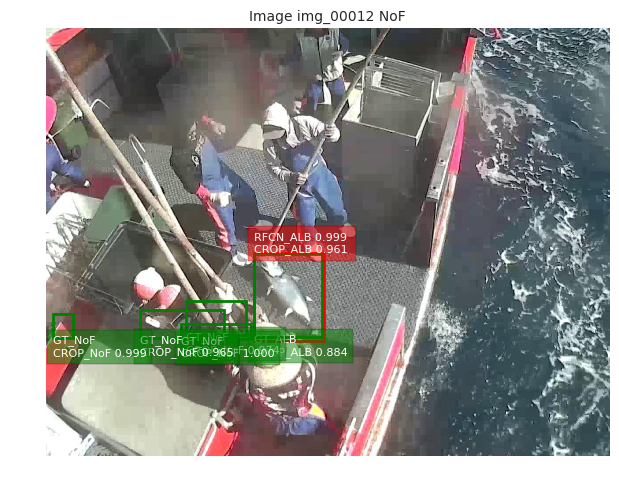

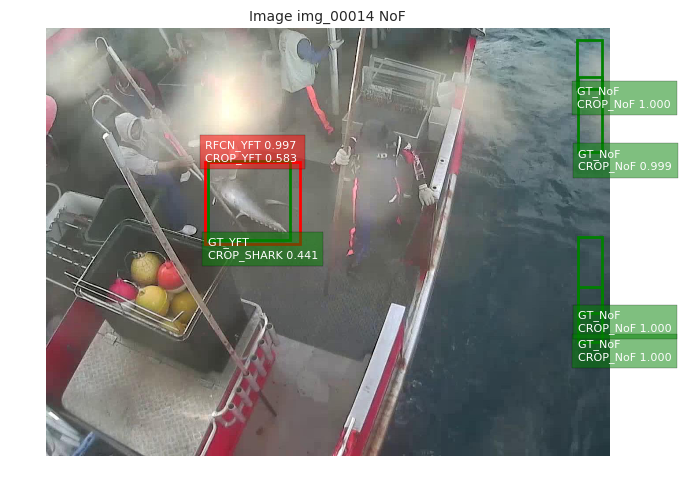

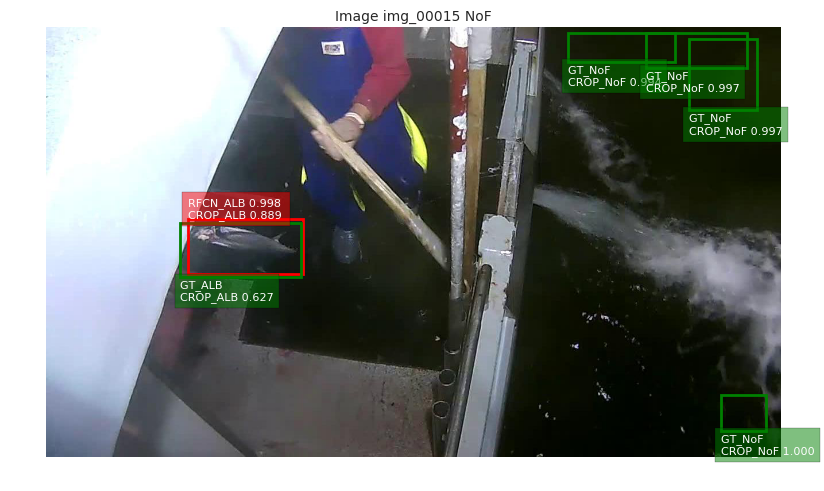

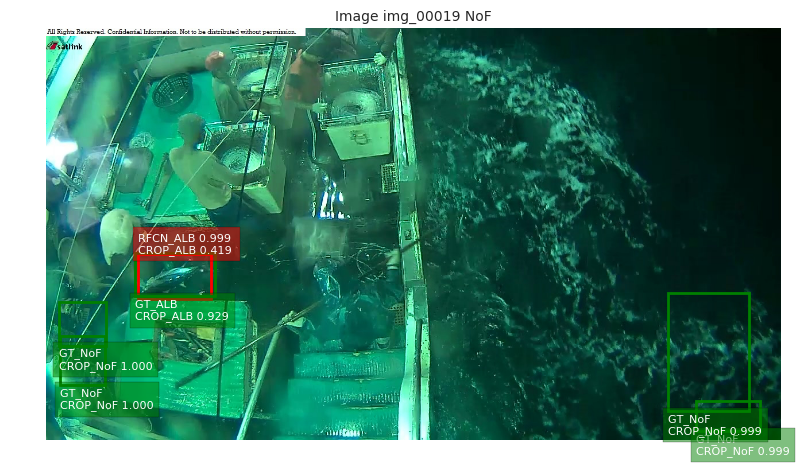

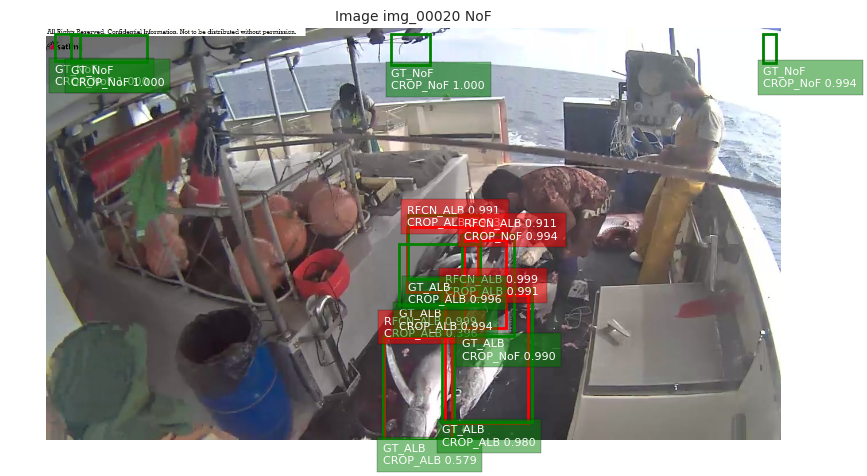

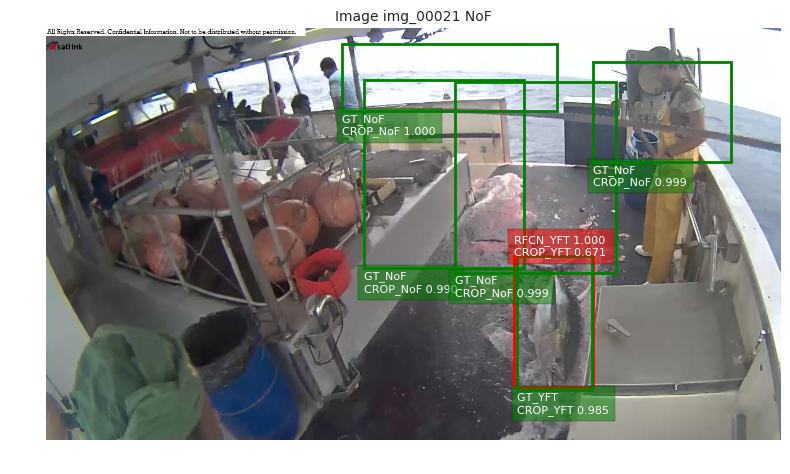

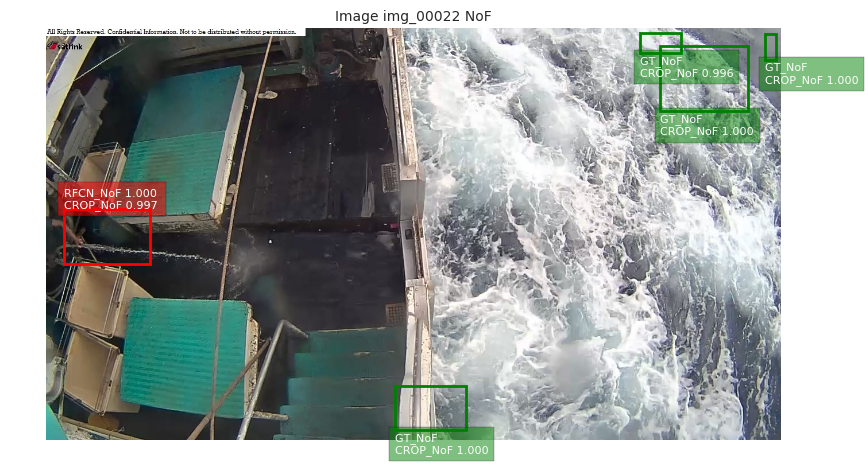

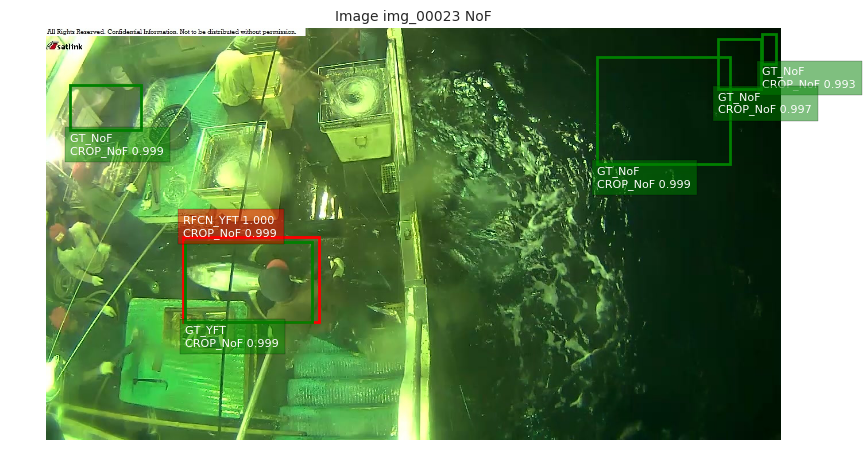

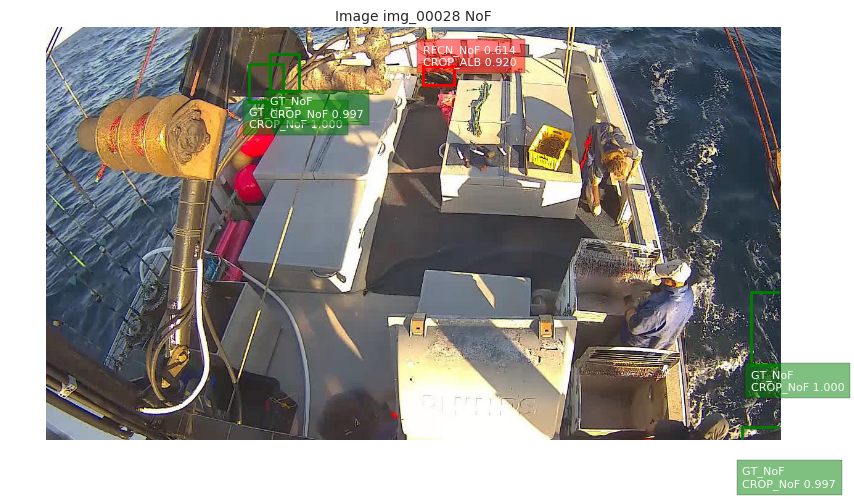

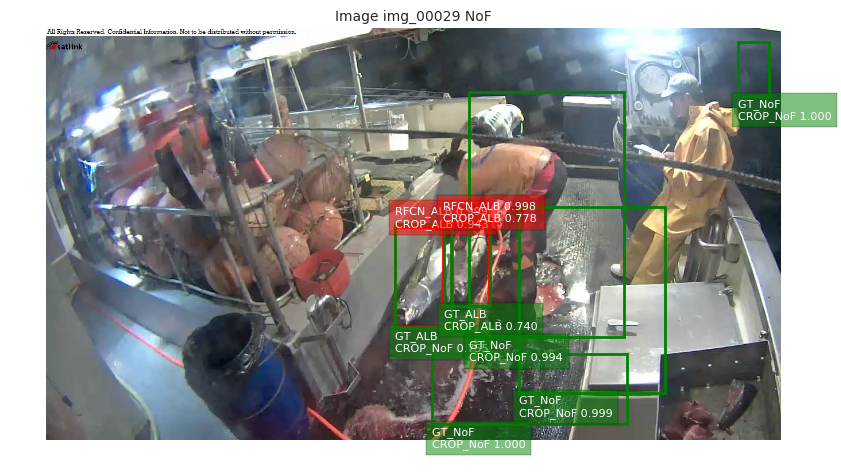

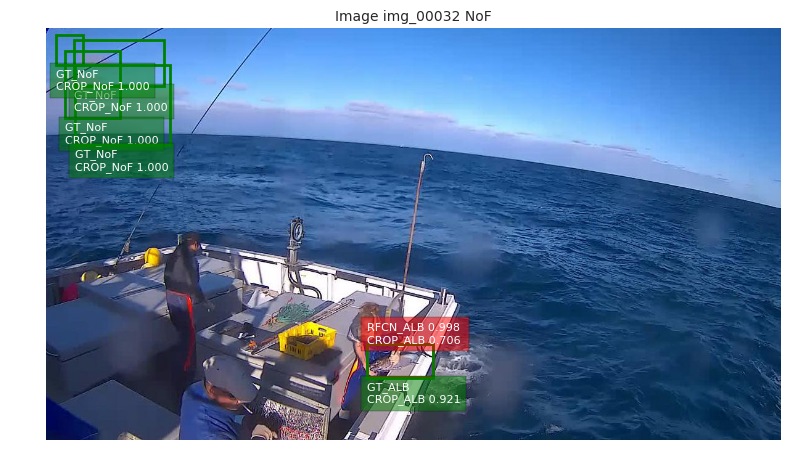

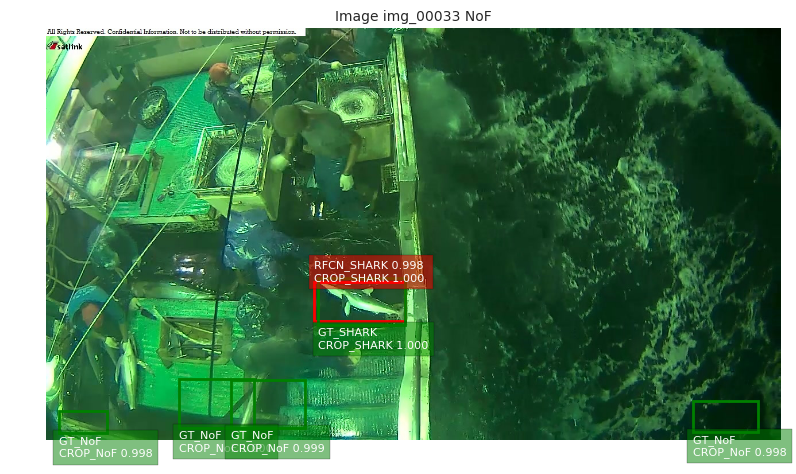

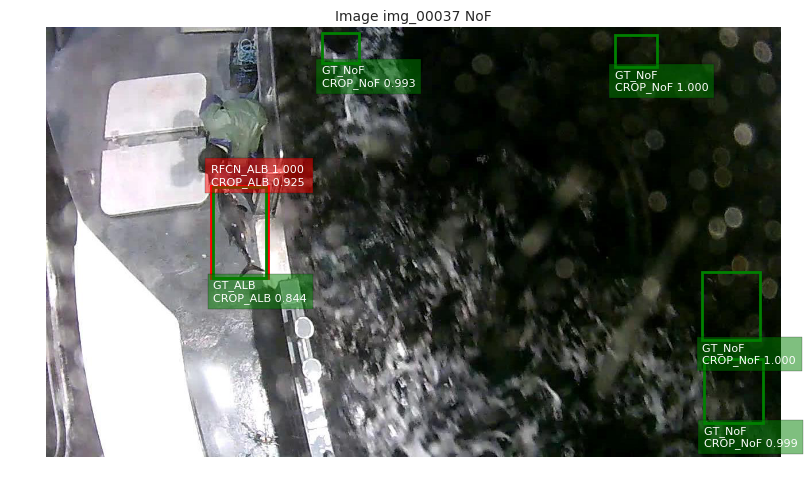

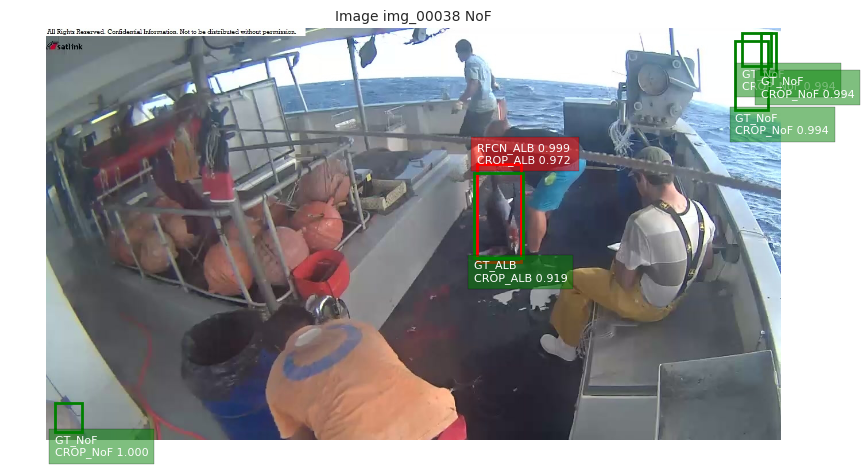

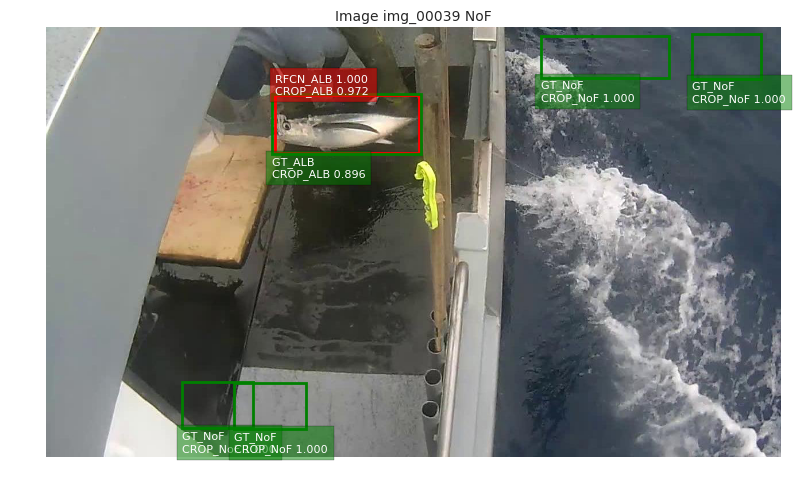

In [14]:
#visualization
#import xml.etree.ElementTree

FISH_CLASSES = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']

with open("../RFCN/ImageSets/Main/test.txt","r") as f:
    ims = f.readlines()
test_files = [im[:-1] for im in ims][1000:]

for j in range(5,20):
    RFCN_dets = test_preds_df.loc[test_preds_df['test_files']==test_files[j]]
    im = Image.open('../RFCN/JPEGImages/'+test_files[j]+'.jpg')
    im = np.asarray(im)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.imshow(im, aspect='equal')
    for index,row in RFCN_dets.iterrows():
        row = row.tolist()
        bbox = row[5:9]
        RFCN = [row[i] for i in [9,11,13,15,17,19,21,23]]
        BBCROP = [row[i] for i in [10,12,14,16,18,20,22,24]]
        score_RFCN = max(RFCN)
        score_BBCROP = max(BBCROP)
        index_RFCN = RFCN.index(score_RFCN)
        index_BBCROP = BBCROP.index(score_BBCROP)
        class_RFCN = FISH_CLASSES[index_RFCN]
        class_BBCROP = FISH_CLASSES[index_BBCROP]
        ax.add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], fill=False, edgecolor='red', linewidth=2))
        ax.text(bbox[0], bbox[1] - 2, 'RFCN_{:s} {:.3f} \nCROP_{:s} {:.3f}'.format(class_RFCN, score_RFCN, class_BBCROP, score_BBCROP), bbox=dict(facecolor='red', alpha=0.5), fontsize=8, color='white')
    GT_dets = GT_crop_BBClassifier_preds.loc[GT_crop_BBClassifier_preds['image_files']==test_files[j]]
    for index,row in GT_dets.iterrows():
        row = row.tolist()
        bbox = row[3:7]
        BBCROP = row[7:]
        score_BBCROP = max(BBCROP)
        index_BBCROP = BBCROP.index(score_BBCROP)
        class_BBCROP = FISH_CLASSES[index_BBCROP]
        ax.add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], fill=False, edgecolor='green', linewidth=2))
        ax.text(bbox[0], bbox[3] + 40, 'GT_{:s} \nCROP_{:s} {:.3f}'.format(row[1], class_BBCROP, score_BBCROP), bbox=dict(facecolor='green', alpha=0.5), fontsize=8, color='white')
#     root = xml.etree.ElementTree.parse('../RFCN/Annotations/'+test_files[j]+'.xml').getroot()
#     for child in root.findall('object'):
#         bbox = [child.find('bndbox').find('xmin').text, child.find('bndbox').find('ymin').text, child.find('bndbox').find('xmax').text,child.find('bndbox').find('ymax').text]
#         bbox = [float(x) for x in bbox]
#         ax.add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], fill=False, edgecolor='green', linewidth=2))
#         ax.text(bbox[0], bbox[3] - 2, 'GT_{:s}'.format(child.find('name').text), bbox=dict(facecolor='green', alpha=0.5), fontsize=8, color='white')  
    ax.set_title(('Image {:s} {:s}').format(test_files[j], row[1]), fontsize=10)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()


In [31]:
#test preds clsMaxAve
FISH_CLASSES = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

# files = glob.glob('./checkpoints/checkpoint2/*')
# val_losses = [float(f.split('-')[-1][:-5]) for f in files]
# index = val_losses.index(min(val_losses))
# print('Loading model from', files[index])
# model = load_model(files[index])
print('Loading model from weights.004-0.0565.hdf5')
model = load_model('./checkpoints/checkpoint2/weights.004-0.0565.hdf5')

test_crop_preds = model.predict(X_test_crop, batch_size=BatchSize, verbose=1)
#test_crop_preds = np.vstack(outputs)[:,4:]

with open("../RFCN/ImageSets/Main/test.txt","r") as f:
    ims = f.readlines()
test_files = [im[:-1]+'.jpg' for im in ims]

count = np.zeros(len(test_files))

test_preds = np.ndarray((len(test_files), test_crop_preds.shape[1]), dtype=np.float32)
for j in range(len(test_files)):
    if j%1000 == 0:
        print(j)
    file = test_files[j]
    test_preds_im = []
    for i in range(len(test_crop_files)):
        if test_crop_files[i][:9] == file[:9]:
            test_preds_im.append(test_crop_preds[i])
    test_preds_im = np.asarray(test_preds_im)
    score_max = np.max(test_preds_im, axis=1)
    inds = np.argmax(test_preds_im, axis=1)
    labels = [FISH_CLASSES[ind] for ind in inds]
    columns = FISH_CLASSES[:]
    test_preds_im_df = pd.DataFrame(test_preds_im, columns=columns)
    test_preds_im_df['max_cls'] = labels
    test_preds_im_df['max_score'] = score_max 
    test_preds_im_df['Counts'] = test_preds_im_df.groupby(['max_cls'])['max_cls'].transform('count')
    idx = test_preds_im_df.groupby(['max_cls'])['max_score'].transform(max) == test_preds_im_df['max_score']
    test_preds_im_df = test_preds_im_df[idx]
    count[j] = test_preds_im_df.shape[0]
    l = FISH_CLASSES.copy()
    l.append('Counts')
    test_preds_im_array = test_preds_im_df[l].as_matrix() 
    test_preds[j] = np.average(test_preds_im_array[:,:-1], axis=0, weights=test_preds_im_array[:,-1], returned=False)

Loading model from weights.003-0.0761.hdf5
6037/6037 [==============================] - 64s    
0
1000
2000
3000
4000


In [33]:
#temperature
T = 2.5
test_preds_T = np.exp(np.log(test_preds)/T)
test_preds_T = test_preds_T/np.sum(test_preds_T, axis=1, keepdims=True)

In [34]:
#calculate train logloss
FISH_CLASSES = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
#FISH_CLASSES = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']

train_files = test_files[1000:]
train_preds = test_preds_T[1000:,:]
with open("../RFCN/ImageSets/Main/train_test.txt","r") as f:
    train_file_labels = f.readlines()

log_losses = []
for i in range(len(train_preds)):
    im = train_files[i][:-4]
    for im_label in train_file_labels:
        if im_label[:9] == im:
            label = im_label[10:-1]
            index = FISH_CLASSES.index(label)
            log_losses.append(-math.log(train_preds[i,index]))
log_loss = sum(log_losses) / float(len(log_losses))
print('logloss of train is', log_loss )

logloss of train is 0.9195452458092187


In [53]:
#test submission
FISH_CLASSES = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
submission = pd.DataFrame(test_preds_T[:1000,:], columns=FISH_CLASSES)
submission.insert(0, 'image', test_files[:1000])

info = 'RFCN_AGONOSTICnms_'+RFCN_MODEL+'_BBCROP_resnet50_clsMaxAve_conf{:.2f}_T{}_'.format(CONF_THRESH, T) + '{:.4f}'.format(log_loss)
sub_file = 'submission_' + info + '.csv'
submission.to_csv(sub_file, index=False)

In [ ]:
###clear checkpoints folder

if not os.path.exists('./checkpoints'):
    os.mkdir('./checkpoints')
files = glob.glob('./checkpoints/*')
for f in files:
    os.remove(f)

In [ ]:
###clear logs folder

if not os.path.exists('./logs'):
    os.mkdir('./logs')
files = glob.glob('./logs/*')
for f in files:
    os.remove(f)